# Introduction

Welcome to Fredernick Lindemeyer's Project! Our focus revolves around implementing exploratory techniques of the models used to classify the brain waves -- we're identifying the "sentimental" explanation of the predictions that models make, which are often are obscured by the complex and near impossible to understand math.

We decided to focus on nicotine consumption based on previous research conducted on the impact of nicotine on brain waves. There is common consensus that there is a causal effect in the increase in alpha waves when intoxicated on nicotine. Nicotine has a half life of 2 hours on the brain. In a study (Kang et al), the researchers measured EEG within 5 minutes after subject smoked one cigarette after a 2 hour period of sobreity. We plan on replicating this data collection method

In general, we hypothesize an increase in alpha waves when Frederick smokes with his vape. We plan on using two models, the EEGNet architecture which examplifies a black box model, and a basic logistic regression classifier, which corresponds to an interpretable model to verify this claim, in addition with some basic visualizations.

# Data Collection and Cleaning

Our data has no control. It was haphazardly collected from a Muse headband (the first one I think) by Frederick with him recording times when ever he smoked from a vape. There are four sessions total with each session having their own external factors (e.g. time of day, the accelormeter, amount of nicotine taken in, etc.) that we will not be taking into account potentially decreasing the data quality; however, each session has a period of sobriety and intoxication from the nicotine that should contain signals.

### Muse information

The Muse's sampling rate is >220Hz for raw EEG. Since alpha waves occilate around 8-12 Hz, this well satisfies the Nyquist Theorem. Muse allows four different types of return values: absolute power bands, raw eeg, discrete frequency, and spectrogram. The Muse also only collects data from the regions TP9, AF7, AF8, and TP10.

For this project, we plan on using the raw EEG as the training data for the EEGNet, and the absolute power band data on the logistic regression classifier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn import linear_model
import os
import torch
# import lime

## Metadata Review:

The first thing to note, is what the descriptions of each of the data values indicate based on [Mind Monitor](https://mind-monitor.com/FAQ.php). For more detail check [here](https://mind-monitor.com/Technical_Manual.php):

| Column(s) | Description | Range/Units |
|-|-|-|
| TimeStamp | Date and Time | Year-Month-Day Hour:Minute:Second.Microsecond |
| Delta_{TP9,AF7,AF8,TP10} | Delta brainwaves, for each of the four sensors | Bels |
| Theta_{TP9,AF7,AF8,TP10} | Theta brainwaves, for each of the four sensors | Bels |
| Alpha_{TP9,AF7,AF8,TP10} | Alpha brainwaves, for each of the four sensors | Bels |
| Beta_{TP9,AF7,AF8,TP10} | Beta brainwaves, for each of the four sensors | Bels |
| Gamma_{TP9,AF7,AF8,TP10} | Gamma brainwaves, for each of the four sensors | Bels |
| RAW_{TP9,AF7,AF8,TP10} | RAW brainwaves, for each of the four sensors | 0.0 - 1682.815 uV |
| Accelerometer_{X,Y,Z} |  	Gravity. X = tilt up/down, Y = tilt left/right, Z = vertical up/down | g {-2:+2} |
| HeadBandOn | Basic data quality indicator: if the headband is on the head | 1=True, 0=False |
| HSI_{TP9,AF7,AF8,TP10} | Data quality, for each of the four sensors (HSI=Horse Shoe Indicator) | 1=True, 0=False |
| Battery | Battery charge percentage | %/100 |
| Elements | Data markers such as Blink, Jaw_Clench, or numbered markers | |

Notes:
* Sensor Location
  * AF7: Left Forehead (dependent on headsize)
  * AF8: Right Forehead (dependent on headsize)
  * TP9: Left Ear
  * TP10: Right Ear
* Abolute info
  * frequency spectrum
    * Delta: 1-4Hz
    * Theta: 4-8Hz
    * **Alpha**: 7.5-13Hz
    * Beta: 13-30Hz
    * Gamma: 30-44Hz
  * absolute band power: based on the **logarithm** of the power spectral density of EEG data for each channel
    * layman explanation: bigger the number, the more brain wave frequency collected in that region
  * normed to {-1,+1}

# Analytics

Since one of the main problems we encountered was the nonstandardized data, we thought the best method of practice is to analyze the data in their own sessions rather than combining them. We first conduct some basic visualizations to verify the existance of signals in the data.

We set moving average batch to 15 arbitrarilty to smooth out the graph.

In [2]:
# Data File Paths
session_one_fp = os.path.join("data","session_one","mindMonitor_2021-02-10--09-18-15.csv")
session_two_fp = os.path.join("data","session_two","mindMonitor_2021-02-24--07-21-47.csv")
session_three_fp = os.path.join("data","session_three","mindMonitor_2021-03-03--12-17-29.csv")

#session_four = os.listdir("data/session_four")

# Selections
sensors = ["AF7", "AF8", "TP9", "TP10"]
waves = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
AF7, AF8, TP9, TP10 = [[f"{wave}_{sensor}" for wave in waves] for sensor in sensors]
DELTA, THETA, ALPHA, BETA, GAMMA = [[f"{wave}_{sensor}" for sensor in sensors] for wave in waves]

BATCH = 5 # for smoothing

# Visual Colorations
reg = "blue" 
intoxC = "red"
soberC = "green"
brainWaveC = "black"

# Helper Functions
def moving_avg(arr:list, n:int) -> np.array:
    """
    returns a list of moving mean from arr with n-size batches
    """
    return np.array([np.mean(arr[i:i+n]) for i in range(len(arr) - n)])

def get_regression(period:list,wave_data:np.array) -> (float, float):
    """
    returns the linear regression plot data given training data
    """
    y = wave_data[period[0]:period[1]]
    X = np.arange(len(y)).reshape(-1, 1)
    mdl = linear_model.LinearRegression()
    mdl.fit(X,y)
    m,b = mdl.coef_[0], mdl.intercept_
    return [period[0], period[1]], [b + m * 0, b + m * len(y)]
    

### Session One
|time|action|
|-|-|
|9:20| vape hit|
|9:21| vape hit|
|9:22| vape hit|
|9:23| got up and got water|
|9:24| coffee two sips|
|9:25| coffee two sips, spilled slightly|
|9:26| coffee two sips|
|9:28| four vape hits|

Session one is mostly a practice run for Frederick as he got used to the data collection process. Our sampling rate is approximately 1Hz, so we are unable to use the raw EEG, however, the band power represents the quantity of frequency so we can draw insight through those attributes.

In [3]:
ses1 = pd.read_csv(session_one_fp, parse_dates=["TimeStamp"])

# Important Time Markers
m1 = ses1.TimeStamp[0]
m2 = datetime(2021,2,10,9,23)
m3 = datetime(2021,2,10,9,28)
m4 = ses1.TimeStamp.iloc[-1]

# Periods
intox1 = [sum(ses1.TimeStamp < m1), sum(ses1.TimeStamp < m2)]
sober1 = [sum(ses1.TimeStamp < m2), sum(ses1.TimeStamp < m3)] # Does not take into account of moving average
intox2 = [sum(ses1.TimeStamp < m3), sum(ses1.TimeStamp < m4)]

# For logistic mdl
ses1_y =  np.concatenate((np.ones(intox1[1]), np.zeros(sober1[1] - sober1[0]), np.ones(intox2[1] - intox2[0])))

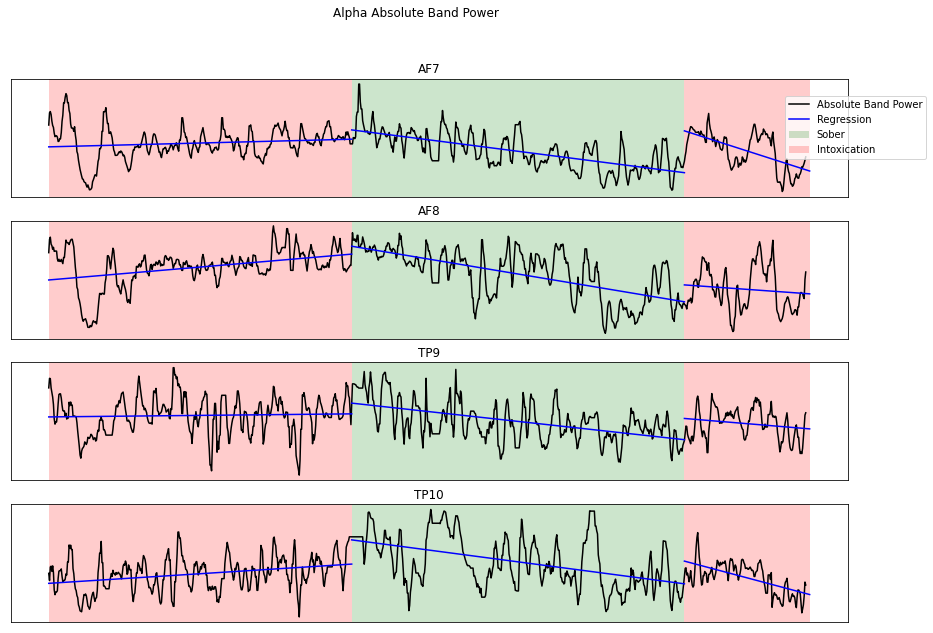

In [4]:
# Coefficient Visualization
fig, ax = plt.subplots(4, 1, figsize=(15, 10))
for i, s in enumerate(ALPHA):
    vals = moving_avg(ses1[s],BATCH)
    
    # Brain Waves
    ax[i].plot(vals, color=brainWaveC, label="Absolute Band Power")
    ax[i].set_title(sensors[i])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    
    # Sobriety
    ax[i].axvspan(sober1[0], sober1[1], facecolor=soberC, alpha=0.2, label="Sober")
    # Intoxication
    ax[i].axvspan(intox1[0], intox1[1], facecolor=intoxC, alpha=0.2, label="Intoxication")
    ax[i].axvspan(intox2[0], intox2[1], facecolor=intoxC, alpha=0.2,)

    # Stepwise TimeSeries Linear Regression
    x, y = get_regression(intox1, vals)
    ax[i].plot(x, y, color=reg, label="Regression")
    x, y = get_regression(sober1, vals)
    ax[i].plot(x, y, color=reg)
    x, y = get_regression(intox2, vals)  
    ax[i].plot(x,y, color=reg)
plt.legend(bbox_to_anchor=(1.1,4.5))
plt.suptitle("Alpha Absolute Band Power")
plt.show()

We appear to replicate the findings, as we see an increase in alpha waves in the first intoxication period and a gradual decrease in the alpha waves across all sensors during sobriety. This is consistent with the existing findings. To better visualize this decrease, we can implmement linear regression on the periods of sobriety and we see that each regression has a strengths of the positive and negative coefficient associated with each period of sobriety and intoxication.

The second period of intoxication appears to to have a sharp decline but this is attributable to the small window of time (8 minutes for the entire session).

Our interest then spread to the non-alpha waves, and see what possible pattern exists, perhaps this change in alpha impacts the other non-alpha waves.

**NOTE**: the periods do not take into account the moving_avg, and therefor can be unrepresentative (albeit minor) of the values

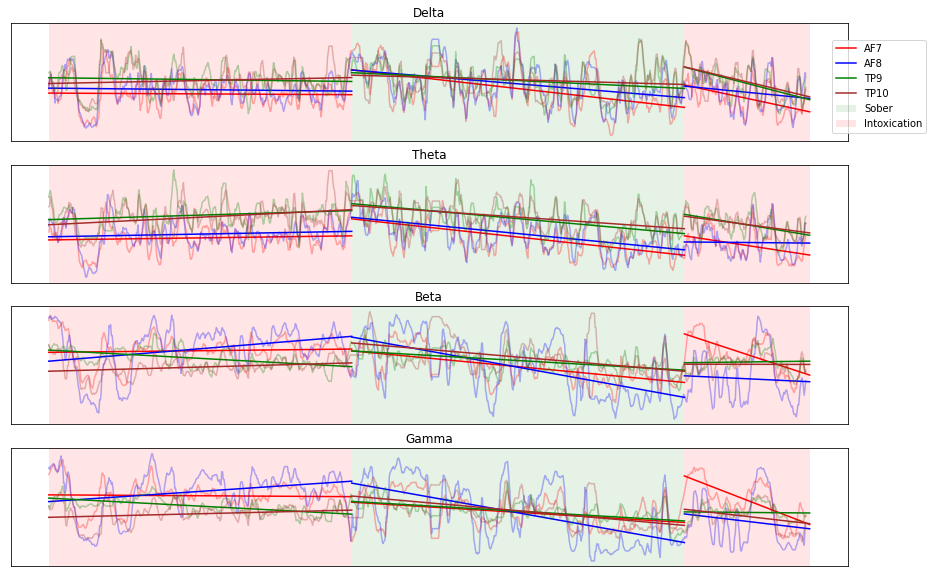

In [5]:
nonalphas = [DELTA, THETA, BETA, GAMMA]
titles = ["Delta", "Theta", "Beta", "Gamma"]
fig, ax = plt.subplots(4, 1, figsize=(15, 10))
color = ["red", "blue", "green", "brown"]

for i, nonalpha in enumerate(nonalphas):
    # Visualization
    for j, s in enumerate(nonalpha):
        vals = moving_avg(ses1[s],BATCH)
        
        # Stepwise TimeSeries Linear Regression
        x, y = get_regression(intox1, vals)
        ax[i].plot(x,y, label=sensors[j], c=color[j])
        x, y = get_regression(sober1, vals)
        ax[i].plot(x,y, label=sensors[j], c=color[j])
        x, y = get_regression(intox2, vals)
        ax[i].plot(x,y, label=sensors[j], c=color[j])

        # Brain Waves
        ax[i].plot(vals, alpha=.3, c=color[j])
    # Sobriety
    ax[i].axvspan(sober1[0], sober1[1], facecolor=soberC, alpha=0.1, label="Sober")
    # Intoxication
    ax[i].axvspan(intox1[0], intox1[1], facecolor=intoxC, alpha=0.1, label="Intoxication")
    ax[i].axvspan(intox2[0], intox2[1], facecolor=intoxC, alpha=0.1,)

    ax[i].set_title(titles[i])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.1,4.5))
plt.show()

We find that the non-alpha waves mimic the increase and decrease patterns found in the alpha band power, implying that the alpha waves are following a general trend rather than being directly impacted by the nicotine. One way to check this decrease is not following a general trend is to normalize alpha. If we change the absolute to relative band power (a normalized form) via the [equation](https://web.archive.org/web/20181105231756/http://developer.choosemuse.com/tools/available-data#Relative_Band_Powers):
$$\text{relative_alpha} = \frac{10^\alpha}{\sum_{i=\alpha, \beta,\delta,\gamma,\theta}10^i}$$
we hopefully are still able to visualize this change in proportionality in alpha.

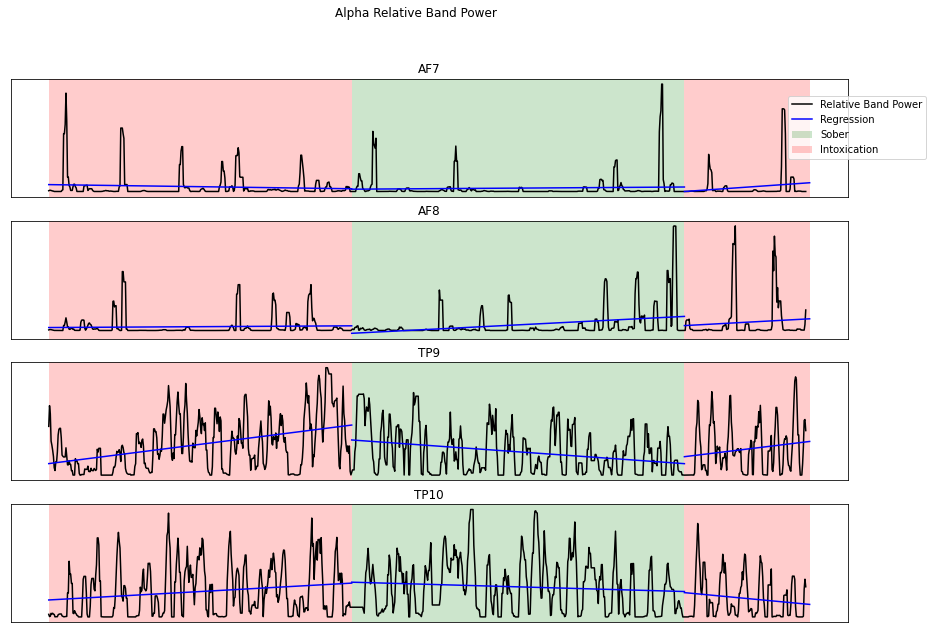

In [6]:
fig, ax = plt.subplots(4,1,figsize=(15,10))
for i, sensor_names in enumerate([AF7, AF8, TP9, TP10]):
    alpha = ses1[sensor_names].loc[:, f"Alpha_{sensors[i]}"] ** 10
    nonalphas = (ses1[sensor_names] ** 10).sum(axis=1)

    relative_alpha = alpha / nonalphas
    vals = moving_avg(relative_alpha, BATCH)
    ax[i].plot(vals, color=brainWaveC, label="Relative Band Power")

    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_title(sensors[i])
    # Sobriety
    ax[i].axvspan(sober1[0], sober1[1], facecolor=soberC, alpha=0.2, label="Sober")
    # Intoxication
    ax[i].axvspan(intox1[0], intox1[1], facecolor=intoxC, alpha=0.2, label="Intoxication")
    ax[i].axvspan(intox2[0], intox2[1], facecolor=intoxC, alpha=0.2,)

    # Stepwise TimeSeries Linear Regression
    x, y = get_regression(intox1, vals)
    ax[i].plot(x, y, color=reg, label="Regression")
    x, y = get_regression(sober1, vals)
    ax[i].plot(x, y, color=reg)
    x, y = get_regression(intox2, vals)  
    ax[i].plot(x,y, color=reg)
plt.legend(bbox_to_anchor=(1.1,4.5))
plt.suptitle("Alpha Relative Band Power")
plt.show()

We do see an trend we are looking for strongly in the TP sensors. The AF sensors appears to have similar results, but they are not as strongly represented compared to TP. We believe this is consistent with the existing findings (double check). We will procceed to other the sessions and hopefully the other sessions will also have the signal we are looking for.

### Session Two

|time|action|
|-|-|
|0:00-6:36| normal breathing focusing on nothing|
|6:36-6:40| stressful thought|
|6:45-7:00| writing|
|8:45-9:15| focussed on clock|
|9:15-9:30| writing|
|9:30-10:25| normal breathing focusing on nothing|
|10:25| picked up vape and inhaled|
|10:45| picked up vape and inhaled (swallowed)|
|11:25| picked up vape and inhaled|
|11:45| picked up vape and inhaled (swallowed)|
|11:45-15:00| Continued to vape every minute until 15:00|
|15:00-20:00| normal breathing focusing on nothing|
|20:00| end writing|

|external variable| description|
|-|-|
|Setting| In my living room, sitting at my desk|
|Ambient noise| Birds chirping
|Vape used| Smok Novo X at 24watts|
|Salt Nicotine used|  50mg Apple by Reds|

We will be conducting the same visual tests from session one, but without looking at the non-alpha graphs. We shall look at just the 


In [7]:
ses2 = pd.read_csv(session_two_fp, parse_dates=["TimeStamp"])

# Time Markers
m1 = ses2.TimeStamp[0]
m2 = ses2.TimeStamp[0] + timedelta(seconds=60 * 10 + 25)
m3 = ses2.TimeStamp[0] + timedelta(seconds=60*15)
m4 = ses2.TimeStamp.iloc[-1]

sober1 = [sum(ses2.TimeStamp < m1), sum(ses2.TimeStamp < m2)]
intox1 = [sum(ses2.TimeStamp < m2), sum(ses2.TimeStamp < m3)]
sober2 = [sum(ses2.TimeStamp < m3), sum(ses2.TimeStamp < m4)]

# For logistic mdl
ses2_y =  np.concatenate((np.zeros(sober1[1]), np.ones(intox1[1] - intox1[0]), np.zeros(sober2[1] - sober2[0])))

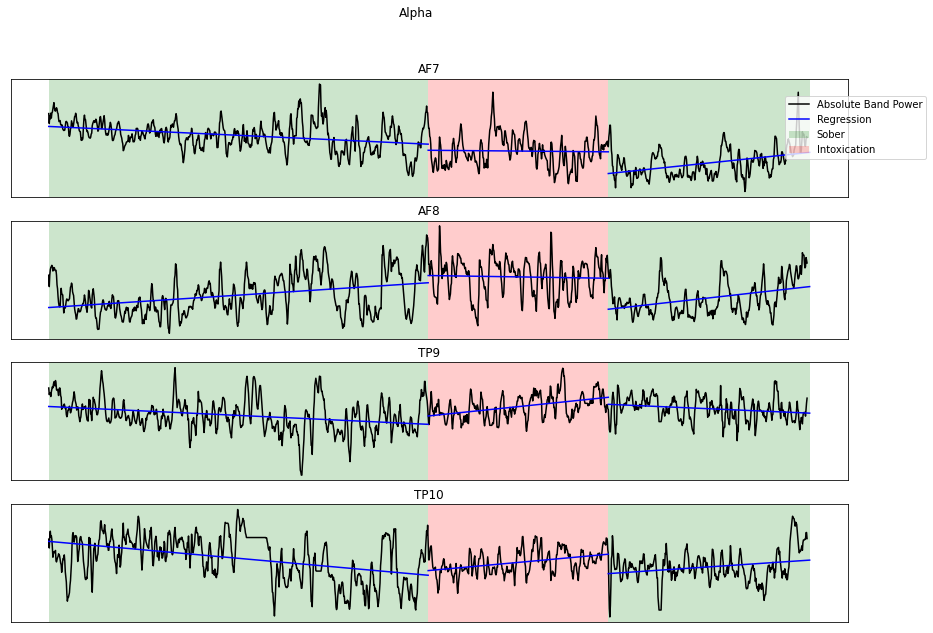

In [8]:
# Visualization
fig, ax = plt.subplots(4, 1, figsize=(15, 10))
for i, s in enumerate(ALPHA):
    vals = moving_avg(ses2[s],BATCH)
    # Brain Waves
    ax[i].plot(vals, color=brainWaveC, label="Absolute Band Power")
    ax[i].set_title(sensors[i])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    
    # Sobriety
    ax[i].axvspan(sober1[0], sober1[1], facecolor=soberC, alpha=0.2, label="Sober")
    # Intoxication
    ax[i].axvspan(intox1[0], intox1[1], facecolor=intoxC, alpha=0.2, label="Intoxication")
    ax[i].axvspan(sober2[0], sober2[1], facecolor=soberC, alpha=0.2,)

    # Stepwise TimeSeries Linear Regression
    x, y = get_regression(sober1, vals)
    ax[i].plot(x, y, color=reg)
    x, y = get_regression(intox1, vals)
    ax[i].plot(x, y, color=reg, label="Regression")
    x, y = get_regression(sober2, vals)  
    ax[i].plot(x,y, color=reg)
plt.legend(bbox_to_anchor=(1.1,4.5))
plt.suptitle("Alpha")
plt.show()

Again, the signal appears strongest in the TP sensors. We see that increase in alpha waves. However, the sober periods appear to be somewhat random in terms of the coeficient. Some sensors show increase, while other indicate a decrease. In addition, the sober period after intoxication mostly likely has the nicotine still impacting the brain because of its relatively long half life.

Given this, and ignoring the second sober period, TP sensors are accurate but AF sensors still do not give the expected trend.

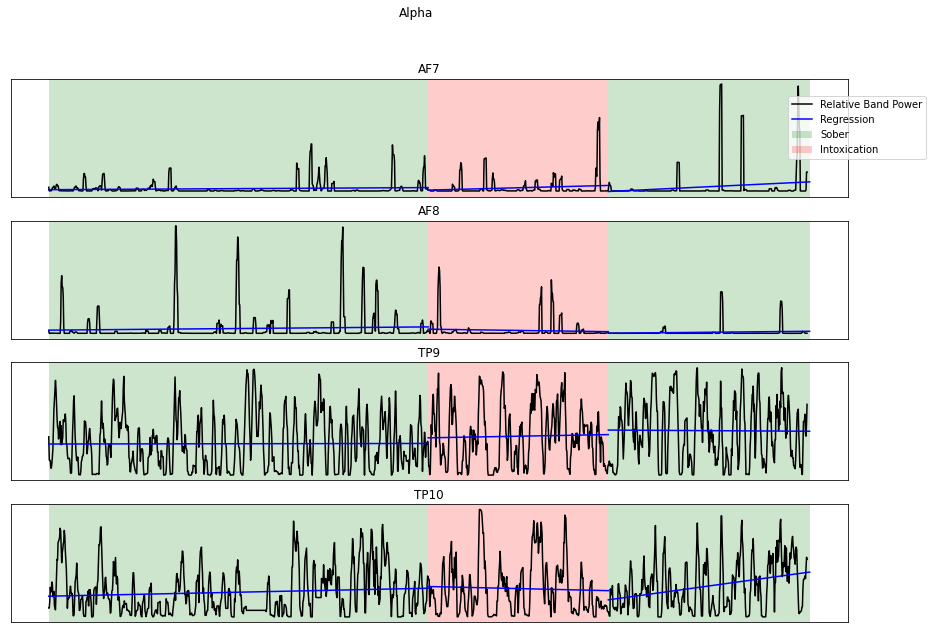

In [9]:
fig, ax = plt.subplots(4,1,figsize=(15,10))
for i, sensor_names in enumerate([AF7, AF8, TP9, TP10]):
    alpha = ses2[sensor_names].loc[:, f"Alpha_{sensors[i]}"] ** 10
    nonalphas = (ses2[sensor_names] ** 10).sum(axis=1)
    relative_alpha = alpha / nonalphas
    vals = moving_avg(relative_alpha, BATCH)
    ax[i].plot(vals, color=brainWaveC, label="Relative Band Power")
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_title(sensors[i])

    # Sobriety
    ax[i].axvspan(sober1[0], sober1[1], facecolor=soberC, alpha=0.2, label="Sober")
    # Intoxication
    ax[i].axvspan(intox1[0], intox1[1], facecolor=intoxC, alpha=0.2, label="Intoxication")
    ax[i].axvspan(sober2[0], sober2[1], facecolor=soberC, alpha=0.2,)

    # Stepwise TimeSeries Linear Regression
    x, y = get_regression(sober1, vals)
    ax[i].plot(x, y, color=reg)
    x, y = get_regression(intox1, vals)
    ax[i].plot(x, y, color=reg, label="Regression")
    x, y = get_regression(sober2, vals)  
    ax[i].plot(x,y, color=reg)
plt.legend(bbox_to_anchor=(1.1,4.5))
plt.suptitle("Alpha")
plt.show()

Unlike session one, the relative band power of alpha implies that the absolute band power in session two is following a trend and therefor cannot be directly affiliated with the nicotine. There is no signal.

### Session Three

|time|action|
|-|-|
|12:18-12:21| no nic|
|12:21-12:24| nic|
|12:24-12:27| no nic|

|external variable| description|
|-|-|
|Setting| Sitting at a chair, minimal movement, consistent and similar intervals of breath|
|Vape| Puff Bar Liche Ice|

According to Frederick, he felt the effects of niccotine most strongly in session three.

In [10]:
ses3 = pd.read_csv(session_three_fp, parse_dates=["TimeStamp"])

# Time Markers
m1 = ses2.TimeStamp[0]
m2 = datetime(2021,3,3,12,21)
m3 = datetime(2021,3,3,12,24)
m4 = datetime(2021,3,3,12,27)

# Periods
sober1 = [sum(ses3.TimeStamp < m1), sum(ses3.TimeStamp < m2)]
intox1 = [sum(ses3.TimeStamp < m2), sum(ses3.TimeStamp < m3)]
sober2 = [sum(ses3.TimeStamp < m3), sum(ses3.TimeStamp < m4)]

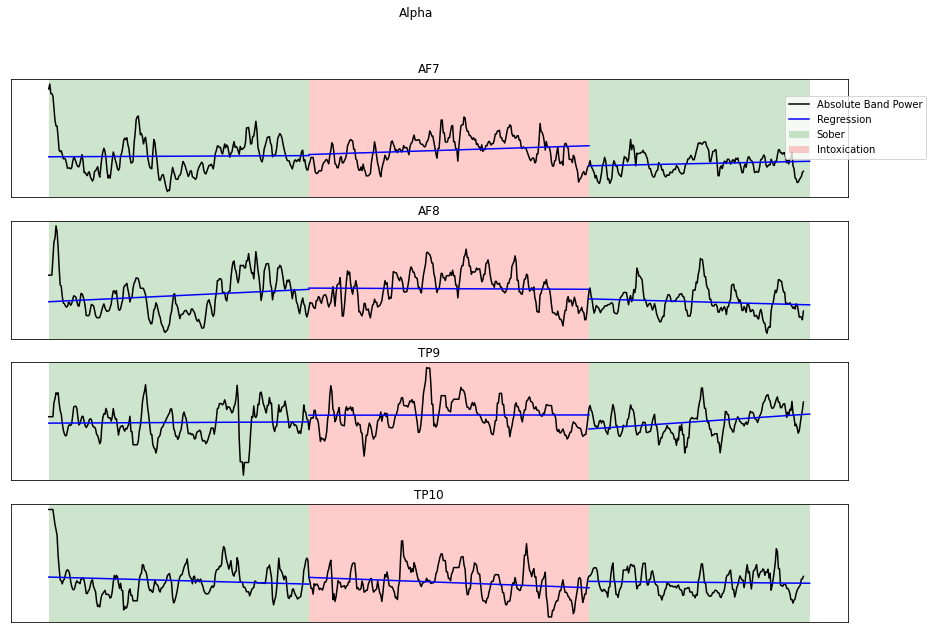

In [13]:
# Visualization
fig, ax = plt.subplots(4, 1, figsize=(15, 10))
for i, s in enumerate(ALPHA):
    vals = moving_avg(ses3[s],BATCH)
    # Brain Waves
    ax[i].plot(vals, color=brainWaveC, label="Absolute Band Power")
    ax[i].set_title(sensors[i])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    
    # Sobriety
    ax[i].axvspan(sober1[0], sober1[1], facecolor=soberC, alpha=0.2, label="Sober")
    # Intoxication
    ax[i].axvspan(intox1[0], intox1[1], facecolor=intoxC, alpha=0.2, label="Intoxication")
    ax[i].axvspan(sober2[0], sober2[1], facecolor=soberC, alpha=0.2,)

    # Stepwise TimeSeries Linear Regression
    x, y = get_regression(sober1, vals)
    ax[i].plot(x, y, color=reg)
    x, y = get_regression(intox1, vals)
    ax[i].plot(x, y, color=reg, label="Regression")
    x, y = get_regression(sober2, vals)  
    ax[i].plot(x,y, color=reg)
plt.legend(bbox_to_anchor=(1.1,4.5))
plt.suptitle("Alpha")
plt.show()

The waves are a lot more stable compartive to the previous two sessions.

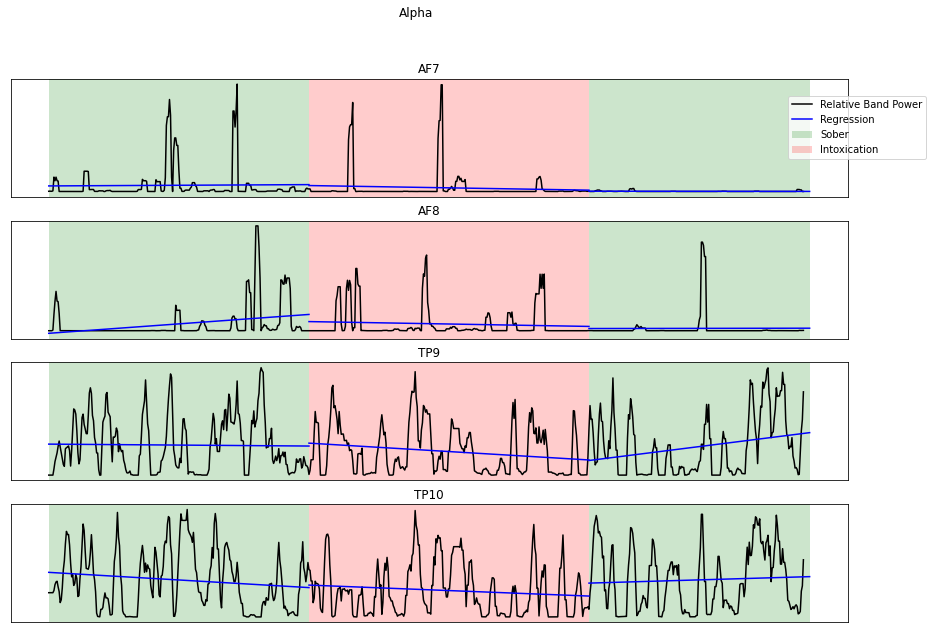

In [14]:
fig, ax = plt.subplots(4,1,figsize=(15,10))
for i, sensor_names in enumerate([AF7, AF8, TP9, TP10]):
    alpha = ses3[sensor_names].loc[:, f"Alpha_{sensors[i]}"] ** 10
    nonalphas = (ses3[sensor_names] ** 10).sum(axis=1)
    relative_alpha = alpha / nonalphas
    vals = moving_avg(relative_alpha, BATCH)
    ax[i].plot(vals, color=brainWaveC, label="Relative Band Power")
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_title(sensors[i])
    
    # Sobriety
    ax[i].axvspan(sober1[0], sober1[1], facecolor=soberC, alpha=0.2, label="Sober")
    # Intoxication
    ax[i].axvspan(intox1[0], intox1[1], facecolor=intoxC, alpha=0.2, label="Intoxication")
    ax[i].axvspan(sober2[0], sober2[1], facecolor=soberC, alpha=0.2,)

    # Stepwise TimeSeries Linear Regression
    x, y = get_regression(sober1, vals)
    ax[i].plot(x, y, color=reg)
    x, y = get_regression(intox1, vals)
    ax[i].plot(x, y, color=reg, label="Regression")
    x, y = get_regression(sober2, vals)  
    ax[i].plot(x,y, color=reg)
plt.legend(bbox_to_anchor=(1.1,4.5))
plt.suptitle("Alpha")
plt.show()

We see a general decrease in the relative alpha band power across all four sensors when intoxicated, which is bad. It is the opposite of what we expect.In addition AF7 appears to be on a decline continuously with the second sober period having almost no activity.

### Session Four

0-5 no nic
5-10 nic
10-15 no nic

session four is a bit different, in that the sampling frequency is drastically increased. This allows us to use the raw EEG in our EEGNet. Our moving average batch is increased to take into account this increase in frequency.

# Modeling Analysis

Theres a common misconception that the sole purpose of models is for functional tasks, i.e. the output is the only thing important; however, models can also be used as an analytics tool. We shall be performing model analytics on two supervised learning models. The logistic classifier algorithm as an example of an interpretable model; the model coefficients have some semantic meaning, and EEGNet, which is a example of a complex model where we would be required to use exploratory techiniques to identify the semantic meaning.

## Logistic Regression Classifier

There are an inifinite number of ways to parameterize a logistic regression classifier. However, as we are looking for understanding rather then accuracy, there must some interpretation to the parametrics. Initially, we believe a good way to parametize the logistic regression is to take into account five seconds of the graph. To do such, we'll be taking into consideration all the band powers on all four sensors. Therefor the number of parameters should be $\text{num_sensors} * \text{num_waves} * \text{num_rows or time} + 1=101$ taking into the account the bias term. 

However, one of the biggest problems is the curse of dimensionality. There are approximately 101 parameters and the amount of data is most likely not enough. The model would most likely have extremely high variance, however given more data, this analysis should give better insight on what happens during intoxication on nicotine. 

## EEGNet

# Conclusion